In [2]:
import torch
import torch.nn as nn
import pandas as pd
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from PIL import Image
import os
import matplotlib.pyplot as plt

image_dirs = ["data/naodevils/images", "data/bhuman"]
data_dirs = ["data/naodevils/spqr_autolabel_and_manual_train_patchified.csv", "data/bhuman/b-alls-2019_train_patchified.csv"]
val_dirs = ["data/naodevils/spqr_manual_val_patchified.csv", "data/bhuman/b-alls-2019_val_patchified.csv"]


In [3]:
class BallDataset(Dataset):
    def __init__(self, data_dirs, images_dirs, transform=None):
        self.data_dirs = data_dirs
        self.images_dirs = images_dirs
        self.transform = transform
        
        dfs = []
        for data_dir, images_dir in zip(data_dirs, images_dirs):
            df = pd.read_csv(data_dir)
            df['images_dir'] = images_dir  
            dfs.append(df)
        self.df = pd.concat(dfs, ignore_index=True)
        
        if self.transform:
            self.dimension = transform.transforms[0].size[0]
        else:
            self.dimension = None

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        img_dir = row["images_dir"]
        
        img = Image.open(os.path.join(img_dir, row["image"])).convert("L")
        
        patch_dim = (row["patch_x"], row["patch_y"], row["patch_x"] + row["patch_size"], row["patch_y"] + row["patch_size"])
        patch = img.crop(patch_dim)
        
        resize_ratio = self.dimension / row["patch_size"] if self.dimension else 1
        
        if row["patch_contains_ball"]:
            x = (row["center_x"] - row["patch_x"]) * resize_ratio
            y = (row["center_y"] - row["patch_y"]) * resize_ratio
            r = row["radius"] * resize_ratio
        else:
            x, y, r = float('nan'), float('nan'), float('nan')
        
        if self.transform:
            patch = self.transform(patch)
        
        patch = patch * 255.0

        #assert pd.isna(x) or x <= 32, (row["patch_x"], row["patch_size"], row["center_x"], x)

        return patch, row["patch_contains_ball"], {"x": x, "y": y, "r": r}
    
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
])

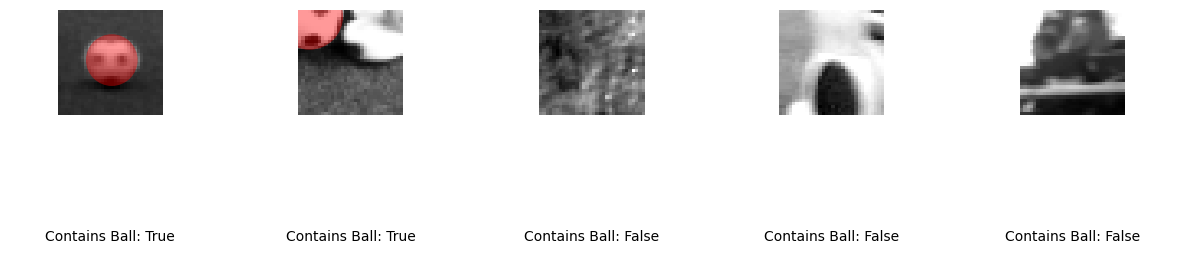

In [5]:
from matplotlib.patches import Circle

dataset = BallDataset(data_dirs, image_dirs, transform)
validation = BallDataset(val_dirs, image_dirs, transform)

batch_size = 256
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation, batch_size=batch_size, shuffle=True)

sample = next(iter(data_loader))

num_images = 5

ig, axes = plt.subplots(2, num_images, figsize=(num_images * 3, 3))

for i in range(num_images):
    axes[0, i].imshow(sample[0][i][0], cmap='gray')
    if sample[1][i]:
        c = Circle((sample[2]["x"][i].item(),sample[2]["y"][i].item()), sample[2]["r"][i].item())
        c.set_facecolor((1.0,0.,0.,0.4))
        axes[0, i].add_patch(c)
    axes[0, i].axis('off')
    axes[1, i].text(0.5, 0, f'Contains Ball: {sample[1][i]}', horizontalalignment='center')  # Add text under each image
    axes[1, i].axis('off')  # Turn off axis for text

plt.show()

In [6]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, use_residual=False):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.use_residual = use_residual

    def forward(self, x):
        z = self.depthwise(x)
        z = self.pointwise(z)
        z = self.bn(z)
        z = self.relu(z) + x if self.use_residual else self.relu(z)
        return z


class BallPerceptor(nn.Module):
    def __init__(self, backbone_size = 9):
        super(BallPerceptor, self).__init__()
        
        self.conv1 = DepthwiseSeparableConv(1, 8, stride=1)
        self.conv2 = DepthwiseSeparableConv(8, 16, stride=1)
        self.conv3 = DepthwiseSeparableConv(16, 32, stride=1)
        
        backbone_layers = []
        for _ in range(backbone_size):
            backbone_layers.append(DepthwiseSeparableConv(32, 32, stride=1,use_residual=True))

        self.backbone = nn.Sequential(*backbone_layers)

        self.pool = nn.MaxPool2d(2, 2)
 
        self.classifier = nn.Sequential(
            nn.Linear(32 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )
        self.segmenter = nn.Sequential(
            nn.Linear(32 * 4 * 4, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 3), # x, y, r
        )

    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = self.pool(self.conv3(x))
        
        x = self.backbone(x)

        feature_map = x.view(-1, 32 * 4 * 4)

        classification = self.classifier(feature_map) if self.training else torch.sigmoid(self.classifier(feature_map))
        segmentation = self.segmenter(feature_map)
        return classification, segmentation

In [7]:
from torch.nn.modules.loss import _Loss

class Circular_DIoU(_Loss):
    def __init__(self, size_average=None, reduce=None, reduction: str = 'mean') -> None:
        super().__init__(size_average, reduce, reduction)

    def intersectionArea(self, X1, Y1, R1, X2, Y2, R2):
        d = torch.sqrt(((X2 - X1) * (X2 - X1)) + ((Y2 - Y1) * (Y2 - Y1)))

        # Case 1: no overlap 
        mask_1 = d > R1 + R2

        # Case 2: One circle is fully within the other
        mask_2 = ( d <= (R1 - R2) ) & ( R1 >= R2 )
        mask_3 = ( d <= (R2 - R1) ) & ( R2 > R1 )

        # Case 3: Partial overlap
        mask_else = ~(mask_1 | mask_2 | mask_3)

        intersection_area = torch.zeros_like(d, dtype=torch.float32)

        intersection_area[mask_2] = torch.pi * R2[mask_2] * R2[mask_2]
        intersection_area[mask_3] = torch.pi * R1[mask_3] * R1[mask_3]

        alpha = torch.acos(((R1[mask_else] * R1[mask_else]) + (d[mask_else] * d[mask_else]) - (R2[mask_else] * R2[mask_else])) / (2 * R1[mask_else] * d[mask_else])) * 2
        beta = torch.acos(((R2[mask_else] * R2[mask_else]) + (d[mask_else] * d[mask_else]) - (R1[mask_else] * R1[mask_else])) / (2 * R2[mask_else] * d[mask_else])) * 2
        
        a1 = (0.5 * beta * R2[mask_else] * R2[mask_else] ) - (0.5 * R2[mask_else] * R2[mask_else] * torch.sin(beta))
        a2 = (0.5 * alpha * R1[mask_else] * R1[mask_else]) - (0.5 * R1[mask_else] * R1[mask_else] * torch.sin(alpha))

        intersection_area[mask_else] = a1 + a2

        return intersection_area

    def forward(self, input, target):
        a1 = torch.pi * torch.pow(input[:,2], 2)
        a2 = torch.pi * torch.pow(target[:,2], 2)

        a1inta2 = self.intersectionArea(input[:,0], input[:,1], input[:,2], target[:,0], target[:,1], target[:,2])

        a1una2 = a1 + a2 - a1inta2

        center_diff = input[:,:2] - target[:,:2]

        center_dist = torch.norm(center_diff, dim=-1)
        D = torch.pow(center_dist, 2)/torch.pow(center_dist + input[:,2] + target[:,2], 2)

        DIoU = 1 - a1inta2/a1una2 + D

        if self.reduction == 'mean':
            return DIoU.mean()
        elif self.reduction == 'sum':
            return DIoU.sum()
        else:
            return DIoU


In [8]:
def intersectionArea(X1, Y1, R1, X2, Y2, R2):
        d = torch.sqrt(((X2 - X1) * (X2 - X1)) + ((Y2 - Y1) * (Y2 - Y1)))

        # Case 1: no overlap 
        mask_1 = d > R1 + R2

        # Case 2: One circle is fully within the other
        mask_2 = ( d <= (R1 - R2) ) & ( R1 >= R2 )
        mask_3 = ( d <= (R2 - R1) ) & ( R2 > R1 )

        # Case 3: Partial overlap
        mask_else = ~(mask_1 | mask_2 | mask_3)

        intersection_area = torch.zeros_like(d, dtype=torch.float32)

        intersection_area[mask_2] = torch.pi * R2[mask_2] * R2[mask_2]
        intersection_area[mask_3] = torch.pi * R1[mask_3] * R1[mask_3]

        alpha = torch.acos(((R1[mask_else] * R1[mask_else]) + (d[mask_else] * d[mask_else]) - (R2[mask_else] * R2[mask_else])) / (2 * R1[mask_else] * d[mask_else])) * 2
        beta = torch.acos(((R2[mask_else] * R2[mask_else]) + (d[mask_else] * d[mask_else]) - (R1[mask_else] * R1[mask_else])) / (2 * R2[mask_else] * d[mask_else])) * 2

        a1 = (0.5 * beta * R2[mask_else] * R2[mask_else] ) - (0.5 * R2[mask_else] * R2[mask_else] * torch.sin(beta))
        a2 = (0.5 * alpha * R1[mask_else] * R1[mask_else]) - (0.5 * R1[mask_else] * R1[mask_else] * torch.sin(alpha))

        intersection_area[mask_else] = a1 + a2

        return intersection_area

def IoU(input, target):
        a1 = torch.pi * torch.pow(input[:,2], 2)
        a2 = torch.pi * torch.pow(target[:,2], 2)
        a1inta2 = intersectionArea(input[:,0], input[:,1], input[:,2], target[:,0], target[:,1], target[:,2])
        iou = a1inta2/ (a1 + a2 - a1inta2)
        center_diff = input[:,:2] - target[:,:2]
        center_dist = torch.norm(center_diff, dim=-1)
        D = torch.pow(center_dist, 2)/torch.pow(center_dist + input[:,2] + target[:,2], 2)
        return iou.mean() , D.mean()



# No freeze

In [7]:
torch.cuda.is_available()

True

In [8]:
import tqdm
best_loss = float("inf")
#best_loss = 1.8359

In [9]:
def validate(model: nn.Module, detection_weight: float, best_loss: float):
    model.eval()
    correct = 0
    total = 0
    val_loss = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data in validation_loader:
            images, labels = data[0].to(device), data[1].float().to(device)
            segmentation_gt = torch.stack((data[2]["x"], data[2]["y"], data[2]["r"]), dim=1).to(device).to(torch.float)
            classification_mask = labels == 1.

            classification, segmentation = model(images)

            val_loss += classification_criterion(classification, labels.unsqueeze(1))                    
            if classification_mask.any():
                val_loss += detection_weight * segmentation_criterion(segmentation[classification_mask], segmentation_gt[classification_mask])

            predicted = torch.round(classification)
            total += labels.size(0)
            correct += (predicted == labels.unsqueeze(1)).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    model.train()
    accuracy = 100 * correct / total
    val_loss /= total / batch_size

    # Compute F1-score
    f1 = f1_score(all_labels, all_predictions, average='binary')

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), PATH)

    model.train()
    return val_loss, accuracy, f1*100

In [10]:
from sklearn.metrics import f1_score
from datetime import datetime

@torch.no_grad()
def validate(model: nn.Module, detection_weight: float, best_loss: float, path:str):
    model.eval()
    correct = 0
    total = 0
    val_loss = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data in validation_loader:
            images, labels = data[0].to(device), data[1].float().to(device)
            segmentation_gt = torch.stack((data[2]["x"], data[2]["y"], data[2]["r"]), dim=1).to(device).to(torch.float)
            classification_mask = labels == 1.

            classification, segmentation = model(images)

            val_loss += classification_criterion(classification, labels.unsqueeze(1))                    
            if classification_mask.any():
                val_loss += detection_weight * segmentation_criterion(segmentation[classification_mask], segmentation_gt[classification_mask])
                iou, d = IoU(segmentation[classification_mask], segmentation_gt[classification_mask])
            predicted = torch.round(classification)
            total += labels.size(0)
            correct += (predicted == labels.unsqueeze(1)).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    model.train()
    accuracy = 100 * correct / total
    val_loss /= total / batch_size

    # Compute F1-score
    f1 = f1_score(all_labels, all_predictions, average='binary')

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), path)

    model.train()
    return val_loss, accuracy, f1*100, iou, d


In [11]:
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

dataset = BallDataset(data_dirs, image_dirs, transform)
validation = BallDataset(val_dirs, image_dirs, transform)

batch_size = 256
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
validation_loader = DataLoader(validation, batch_size=batch_size, shuffle=False, num_workers=4)



In [12]:
def load_weights(model, weights_path=None):
    if weights_path is None:
        return model
    weights = torch.load(weights_path)
    model.load_state_dict(weights, strict=False)
    return model

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
p_weight = torch.tensor([0.6]).to(device)
classification_criterion = nn.BCEWithLogitsLoss(pos_weight=p_weight)
segmentation_criterion = Circular_DIoU()

num_epochs = 5
iterations = 5 #how many iterations in total
log_rate = 100
eval_rate = 300


##### CHANGE HERE TO TEST DIFFERENT MODELS##########

path = "results/Maml.pt" #path to save model
best_loss_file = path.replace('.pt', '.txt') #path to save results
weights_path = 'weights/Maml.pt' #path for loading weights

############################################################

In [14]:
device

device(type='cuda')

In [15]:
import os

folder_name = "results"

if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print(f'Folder "{folder_name}" created.')
else:
    print(f'Folder "{folder_name}" already exists.')


Folder "results" already exists.


In [ ]:
detection_weight = 5
best_loss = float("inf")
tot_loss = 0
logs = [] 

for it in range(iterations):
    best_loss = float("inf")
    model = BallPerceptor()
    model = load_weights(model,weights_path)
    optimizer = optim.AdamW(model.parameters(), lr=0.0001)
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, data in tqdm.tqdm(enumerate(data_loader, 0), total=len(dataset)//batch_size):
            inputs, labels = data[0].to(device), data[1].float().to(device)
            segmentation_gt = torch.stack((data[2]["x"], data[2]["y"], data[2]["r"]), dim=1).to(device).to(torch.float)

            classification_mask = labels == 1.

            optimizer.zero_grad()
            classification, segmentation = model(inputs)
            loss = classification_criterion(classification, labels.unsqueeze(1))
            if classification_mask.any():
                loss = detection_weight*segmentation_criterion(segmentation[classification_mask], segmentation_gt[classification_mask]) + loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if (i+1) % log_rate == 0: 
                print('[Epoch %d, Batch %5d] Training loss: %.5f' %
                    (epoch + 1, i + 1, running_loss / log_rate))
                running_loss = 0.0
        
            if (i + 1) % eval_rate == 0:
                val_loss, accuracy, f1, iou, d = validate(model, detection_weight, best_loss, path)
                log = '[Iteration %d, Epoch %d] Accuracy: %f --- F1: %f --- Loss: %f --- IoU: %f --- D: %f' % \
                      (it + 1, epoch + 1, accuracy, f1, val_loss, iou, d)
                print(log)
                logs.append(log)

                if val_loss < best_loss:
                    best_loss = val_loss
                    log = 'Epoch: %d --- Accuracy: %f --- F1: %f  --- Loss: %f --- IoU: %f --- D: %f' % (epoch + 1, accuracy, f1, val_loss, iou, d)
                    

        val_loss, accuracy, f1, iou, d = validate(model, detection_weight, best_loss, path)
        print('Epoch: %d --- Accuracy: %f --- F1: %f --- Loss: %f --- IoU: %f --- D: %f' % (epoch + 1, accuracy, f1, val_loss, iou, d))
    tot_loss += best_loss

avg_loss = tot_loss / iterations
with open(best_loss_file, 'a') as f:
    for l in logs:
        f.write(l + '\n')
    f.write(f'Average loss is: {avg_loss}\n')

print('Finished Training')



In [78]:
@torch.no_grad()
def validate(model: nn.Module, detection_weight: float, best_loss: float, path:str, lower, upper):
    model = model.to(device)  # Ensure model is on the right device
    model.eval()
    correct = 0
    total = 0
    val_loss = 0
    all_labels = []
    all_predictions = []
    
    # For mAP calculation
    all_confidences = []
    all_has_ball = []  # Whether the image has a ball or not
    
    # Track overall metrics across batches
    all_samples = 0
    total_iou = 0
    total_d = 0
    
    with torch.no_grad():
        for data in validation_loader:
            images, labels = data[0].to(device), data[1].float().to(device)
            segmentation_gt = torch.stack((data[2]["x"], data[2]["y"], data[2]["r"]), dim=1).to(device).to(torch.float)
            classification_mask = labels == 1.
            
            classification, segmentation = model(images)
            val_loss += classification_criterion(classification, labels.unsqueeze(1))
            
            # Store classification confidences
            confidences = classification.sigmoid().squeeze(1) if hasattr(classification, 'sigmoid') else classification.squeeze(1)
            all_confidences.extend(confidences.cpu().numpy())
            all_has_ball.extend(labels.cpu().numpy())
            
            if classification_mask.any():
                val_loss += detection_weight * segmentation_criterion(segmentation[classification_mask], segmentation_gt[classification_mask])
                
                # Calculate IoU for this batch
                batch_iou, batch_d = IoU(segmentation[classification_mask], segmentation_gt[classification_mask])
                
                # Accumulate for averaging later
                total_iou += batch_iou.item() * classification_mask.sum().item()
                total_d += batch_d.item() * classification_mask.sum().item()
                all_samples += classification_mask.sum().item()
            
            predicted = torch.round(classification)
            total += labels.size(0)
            correct += (predicted.squeeze(1) == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.squeeze(1).cpu().numpy())
    
    # Calculate average IoU and D
    avg_iou = total_iou / max(all_samples, 1)
    avg_d = total_d / max(all_samples, 1)
    
    # Calculate mAP50-95 using a modified approach that works with our available data
    map_50_95 = calculate_map_50_95(all_confidences, all_has_ball,lower,upper)
    
    # Original metrics
    accuracy = 100 * correct / total
    val_loss /= total / batch_size
    # Compute F1-score
    f1 = f1_score(all_labels, all_predictions, average='binary')
    
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), path)
    
    model.train()
    return val_loss, accuracy, f1*100, avg_iou, avg_d, map_50_95

def calculate_map_50_95(confidences, has_ball,lower, upper):
    """
    Calculate an approximation of mAP50-95 based on classification scores.
    This is a simplified version that works with binary classification.
    
    Args:
        confidences: List of confidence scores
        has_ball: List of ground truth labels (1 = has ball, 0 = no ball)
    
    Returns:
        mAP50-95: Approximated Mean Average Precision
    """
    confidences = np.array(confidences)
    has_ball = np.array(has_ball)
    
    # Define confidence thresholds to simulate IoU thresholds
    thresholds = np.arange(lower, upper+0.5, 0.5)
    
    aps = []
    for threshold in thresholds:
        # For each threshold, calculate predictions
        predictions = confidences >= threshold
        
        # Number of positive ground truths
        n_positives = np.sum(has_ball == 1)
        if n_positives == 0:
            aps.append(0)
            continue
            
        # Sort by confidence score (descending)
        indices = np.argsort(-confidences)
        sorted_predictions = predictions[indices]
        sorted_has_ball = has_ball[indices]
        
        # Calculate cumulative TP and FP
        tp_cumsum = np.cumsum(sorted_predictions & (sorted_has_ball == 1))
        fp_cumsum = np.cumsum(sorted_predictions & (sorted_has_ball == 0))
        
        # Calculate precision and recall
        precision = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-10)
        recall = tp_cumsum / n_positives
        
        # Add sentinel values for interpolation
        precision = np.concatenate(([1.0], precision))
        recall = np.concatenate(([0.0], recall))
        
        # Ensure precision is non-increasing for proper interpolation
        for i in range(len(precision) - 1, 0, -1):
            precision[i-1] = max(precision[i-1], precision[i])
        
        # Calculate AP using all-point interpolation (101-point method)
        ap = 0
        for r in np.linspace(0, 1, 101):
            indices = recall >= r
            if indices.any():
                ap += np.max(precision[indices]) / 101
        
        aps.append(ap)
    
    # Return the mean AP across all thresholds
    return np.mean(aps)

In [102]:
modelBase = BallPerceptor()
weights_path = "results/base.pt"
modelBase = load_weights(modelBase,weights_path)
modelBase.to(device)

BallPerceptor(
  (conv1): DepthwiseSeparableConv(
    (depthwise): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (pointwise): Conv2d(1, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2): DepthwiseSeparableConv(
    (depthwise): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
    (pointwise): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv3): DepthwiseSeparableConv(
    (depthwise): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
    (pointwise): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (bac

In [101]:
modelMaml = BallPerceptor()
weights_path = "results/Maml.pt"
modelMaml = load_weights(modelMaml,weights_path)
modelMaml.to(device)

BallPerceptor(
  (conv1): DepthwiseSeparableConv(
    (depthwise): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (pointwise): Conv2d(1, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2): DepthwiseSeparableConv(
    (depthwise): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
    (pointwise): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv3): DepthwiseSeparableConv(
    (depthwise): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
    (pointwise): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (bac

In [103]:
_, _, _, _, _, map1 = validate(modelBase, 5, 1, path, lower = 0.5, upper = 0.95)
_, _, _, _, _, map2 = validate(modelMaml, 5, 1, path, lower = 0.5, upper = 0.95)
print(map1)
print(map2)

0.47612664631297746
0.4852580555131791


In [104]:
_, _, _, _, _, map1 = validate(modelBase, 5, 1, path, lower = 0.6, upper = 0.95)
_, _, _, _, _, map2 = validate(modelMaml, 5, 1, path, lower = 0.6, upper = 0.95)
print(map1)
print(map2)

0.4399976539810195
0.4569739269588459


In [105]:
_, _, _, _, _, map1 = validate(modelBase, 5, 1, path, lower = 0.7, upper = 0.95)
_, _, _, _, _, map2 = validate(modelMaml, 5, 1, path, lower = 0.7, upper = 0.95)
print(map1)
print(map2)

0.38500830001951386
0.4150158780166046


In [106]:
_, _, _, _, _, map1 = validate(modelBase, 5, 1, path, lower = 0.8, upper = 0.95)
_, _, _, _, _, map2 = validate(modelMaml, 5, 1, path, lower = 0.8, upper = 0.95)
print(map1)
print(map2)

0.009900990099009901
0.009900990099009901
